In [168]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [169]:
def maillage(n):
#
# Une discretisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[
# Le carre [0,1]x[0,1] est maille uniquement avec des triangles;
# Les conditions limites sont de type Dirichlet uniquement   => neumann  =[];
#
# Entrees :
# n : nombre de points par cote du care => Npts points de discretisation au
# total
#
# Sorties :
# coordinates : matrice a deux colonnes. Chaque ligne contient les
# coordonnes 2D d'un des points de la discretisation. Ces sommets seront
# identifies a l'indice de la ligne correspondante dans la matrice
# coordinates.
# elements3 : matrice a trois colonnes. Chaque ligne contient les indices
# des sommets d'un element triangle, dans le sens antihoraire.
# dirichlet : vecteur colonne des indices des sommets de la frontiere de
# Dirichlet.
# neumann : matrice a deux colonnes. Chaque ligne contient les indices
# des deux sommets d'une arete de la frontiere de Neumann.
# (neumann est vide sur cet exemple)
#
##################################################################################
    h=1/(n-1)
    npoin       = n*n ;
    nelem       = 2*(n-1)*(n-1) ;
    coordinates = np.zeros((npoin,2));
    elements3   = (np.zeros((nelem,3))).astype(int) ;
    neumann     = [];
    dirichlet=(np.zeros((4*n-4,1))).astype(int)
    # Coordonnees et connectivites :
    e = -1 ;
    p = -1 ;
    x=np.zeros((n+1,1))
    x[n,0]=1.
    for l in range (n+1):
        x[l,0]=l*h
    for j in range (n):
            for i in range(n):
                p = p + 1
                coordinates[p,0] = x[i,0]
                coordinates[p,1] = x[j,0]
                if ((i != n-1) & (j != n-1)):
                    p1 = p
                    p2 = p1 + 1
                    p3 = p1 + n
                    p4 = p2 + n
                    e = e + 1
                    elements3[e,0] = p1
                    elements3[e,1] = p2
                    elements3[e,2] = p3
                    e = e + 1
                    elements3[e,0] = p4
                    elements3[e,1] = p3
                    elements3[e,2] = p2
    #Liste des sommets de la frontiere de Dirichlet:
    p=-1
    for j in range(n):
        p=p+1
        dirichlet[p,0] = j
    for j in range(n*2-1,n*(n-1),n):
        p=p+1
        dirichlet[p,0] = j
    for j in range(n*n-1,n*n-n-1,-1):
        p=p+1
        dirichlet[p,0] = j
    for j in range(n*n-2*n,n-1,-n):
        p=p+1
        dirichlet[p,0] = j

    return coordinates, elements3, dirichlet, neumann

In [170]:
def show(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements3, coordinates.
#
# Entrees:
# elements3 : matrice a trois colonnes contenant les elements triangles
# de la discretisation, identifies par les indices de leurs trois
# sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    ax= plt.figure().add_subplot(111,projection='3d')
    ax.plot_trisurf(coordinates[:,0],coordinates[:,1],u,linewidth=0.2,antialiased=True,cmap='viridis',edgecolor='k')
    plt.show()

In [171]:
def show_q(coordinates,u):
#
# Fonction d'affichage de la solution u sur le maillage defini par
# elements4, coordinates.
#
# Entrees:
# elements4 : matrice a quatre colonnes contenant les elements
# quadrangles de la discretisation, identifies par les indices de leurs
# quatre sommets.
# coordinates : matrice a deux colonnes contenant les coordonnes 2D des
# points de la discretisation.
# u : vecteur colonne de longueur egale au nombre de lignes de
# coordinates contenant les valeurs de la solution a afficher aux
# points de la discretisation.
#
# Sorties : Aucune, mais la fonction doit s'afficher dans une figure.
##########################################################################
    n = int(np.sqrt(len(coordinates)))

    X = coordinates[:,0].reshape((n,n))
    Y = coordinates[:,1].reshape((n,n))
    Z = u.reshape((n,n))

    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k')
    plt.show

**Partie I : maillage triangulaire et conditions de Dirichlet**

In [172]:
# Définition des fonctions du problème

def f(x,y):
    res = 1
    return res

def g(x,y):
    res = 1
    return res

def u_d(x,y):
    res = 0
    return res

In [173]:
def A_local_stiff(e,coordinates):
#
# Construction de la matrice de raideur élementaire relative à un
# élément triangle
##########################################################################

    p1 = e[0]
    p2 = e[1]
    p3 = e[2]

    x1 = coordinates[p1,0]
    y1 = coordinates[p1,1]
    x2 = coordinates[p2,0]
    y2 = coordinates[p2,1]
    x3 = coordinates[p3,0]
    y3 = coordinates[p3,1]

    # Calcul de alpha
    a = np.array([[x2 - x1,x3 - x1],[y2 - y1,y3 - y1]])
    alpha = np.linalg.det(a)

    # Calcul de T (aire du triangle)
    T = alpha/2

    # Calcul de la matrice de raideur
    A_local_stiff = np.zeros((3,3))
    grad_heta = np.array([[y2-y3,x3-x2],
                 [y3-y1,x1-x3],
                 [y1-y2,x2-x1]])
    grad_heta = (1/alpha) * grad_heta

    for i in range(3):
        for j in range(3):
            A_local_stiff[i,j] = np.dot(grad_heta[i],grad_heta[j])
    A_local_stiff = T * A_local_stiff

    return A_local_stiff


In [174]:
def b_local(e,coordinates):
#
# Construction du second membre relatif à un élément triangle
##########################################################################
    p1 = e[0]
    p2 = e[1]
    p3 = e[2]

    x1 = coordinates[p1,0]
    y1 = coordinates[p1,1]
    x2 = coordinates[p2,0]
    y2 = coordinates[p2,1]
    x3 = coordinates[p3,0]
    y3 = coordinates[p3,1]

    # Calcul de alpha
    a = np.array([[x2 - x1,x3 - x1],[y2 - y1,y3 - y1]])
    alpha = np.linalg.det(a)

    # Calcul de G (centre du triangle)
    g1 = (x1+x2+x3) / 3
    g2 = (y1+y2+y3) / 3

    # Calcul de l'intégrale sur le triangle
    integral = f(g1,g2)*alpha/6
    return integral

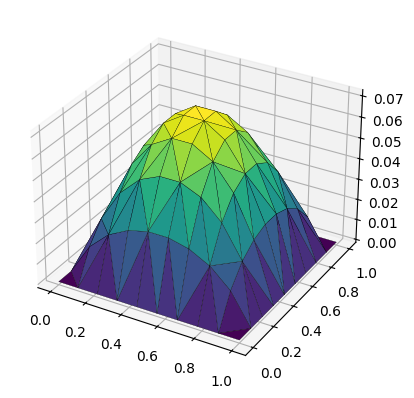

In [175]:
n = 10
n_pts = n*n
coordinates, elements3, dirichlet, neumann = maillage(n)

# Construction de b
b = np.zeros((n*n,1))
for e in elements3:
    for s in range(3):
        index = e[s]
        b[index] += b_local(e,coordinates)

# COnstruction de A
A = scps.csr_matrix((n_pts, n_pts), dtype=float)
for e in elements3:
    A_loc = A_local_stiff(e,coordinates)
    for i in range(3):
        for j in range(3):
            A[e[i],e[j]] += A_loc[i,j]

# Conditions de Dirichlet
for s in dirichlet:
    b[s] = u_d(coordinates[s,0], coordinates[s,1])
    A[s,:] = np.zeros((1,n_pts))
    A[s,s] = 1

# Calcul de la solution
x = np.linalg.solve(A.toarray(),b)
show(coordinates,x[:,0])

**Partie II : maillage mixte et ajoût des conditions de Neumann**

In [176]:
def A_local_stiff_q(e,coordinates):
#
# Construction de la matrice de raideur élementaire relative à un
# élément quadrangle
##########################################################################
    p1 = e[0]
    p2 = e[1]
    p3 = e[2]
    p4 = e[3]

    x1 = coordinates[p1,0]
    y1 = coordinates[p1,1]
    x2 = coordinates[p2,0]
    y2 = coordinates[p2,1]
    x3 = coordinates[p3,0]
    y3 = coordinates[p3,1]
    x4 = coordinates[p4,0]
    y4 = coordinates[p4,1]

    # Calcul de alpha
    a = np.array([[x2 - x1,x4 - x1],[y2 - y1,y4 - y1]])
    alpha = np.linalg.det(a)

    T = alpha # aire du quadrangle

    # Calcul de la matrice de raideur
    J = np.array([[x2-x1,x4-x1],
                  [y2-y1,y4-y1]])
    M = np.transpose(J)*J
    a = M[0,0]
    b = M[1,0]
    c = M[1,1]

    A_local_stiff = np.zeros((4,4))
    A_local_stiff[0,0] = ((a+c)/3 + b/2) * alpha
    A_local_stiff[0,1] = (c/6 - a/3) * alpha
    A_local_stiff[0,2] = -1 * ((a+c)/6 + b/2) * alpha
    A_local_stiff[0,3] = (a/6 - c/3) * alpha

    A_local_stiff[1,0] = (c/6 - a/3) * alpha
    A_local_stiff[1,1] = ((a+c)/3 - b/2) * alpha
    A_local_stiff[1,2] = (a/6 - c/3) * alpha
    A_local_stiff[1,3] = (b/2 - (a+c)/3) * alpha

    A_local_stiff[2,0] = -1 * ((a+c)/6 + b/2) * alpha
    A_local_stiff[2,1] = (a/6 - c/3) * alpha
    A_local_stiff[2,2] = ((a+c)/3 + b/2) * alpha
    A_local_stiff[2,3] = (c/6 - a/3) * alpha

    A_local_stiff[3,0] = (a/6 - c/3) * alpha
    A_local_stiff[3,1] = (b/2 - (a+c)/3) * alpha
    A_local_stiff[3,2] = (c/6 - a/3) * alpha
    A_local_stiff[3,3] = ((a+c)/3 - b/2) * alpha

    return A_local_stiff


In [177]:
def b_local_q(e,coordinates):
#
# Construction du second membre relatif à un élément quadrangle
##########################################################################
    p1 = e[0]
    p2 = e[1]
    p3 = e[2]
    p4 = e[3]

    x1 = coordinates[p1,0]
    y1 = coordinates[p1,1]
    x2 = coordinates[p2,0]
    y2 = coordinates[p2,1]
    x3 = coordinates[p3,0]
    y3 = coordinates[p3,1]
    x4 = coordinates[p4,0]
    y4 = coordinates[p4,1]

    # Calcul de alpha
    a = np.array([[x2 - x1,x3 - x1],[y2 - y1,y3 - y1]])
    alpha = np.linalg.det(a)

    # Calcul de G (centre du quadrangle)
    g1 = (x1+x2+x3+x4) / 4
    g2 = (y1+y2+y3+y4) / 4

    # Calcul de l'intégrale sur le quadrangle
    integral = f(g1,g2)*alpha/4
    return integral

In [178]:
############################# Maillage mixte ################
e3=np.array([[1,2,12],[2,3,12],[3,4,14],[4,5,14],[2,15,3],[3,15,4]]).astype(int)
e4=np.array([[0,1,12,11],[11,12,13,10],[12,3,14,13],[10,13,8,9],[13,14,7,8],[14,5,6,7]]).astype(int)
dds=np.array([2,15,4,6,7,8,9,10,11,0]).astype(int)
nns=np.array([[4,5],[5,6],[0,1],[1,2]]).astype(int)
ccs=np.array([[0.,0.],[0.33333333333333,0],[0.53333333333333,0.],
                      [0.66666666666667,0.33333333333333],[1.,0.47],[1,0.66666666666667],
                     [1.,1.],[0.66666666666667,1.],[0.33333333333333,1.], [0.,1.],
                     [0.,0.66666666666667],[0.,0.33333333333333],[0.33333333333333,0.33333333333333],
                     [0.33333333333333,0.66666666666667],[0.66666666666667,0.66666666666667],[1.,0.]])

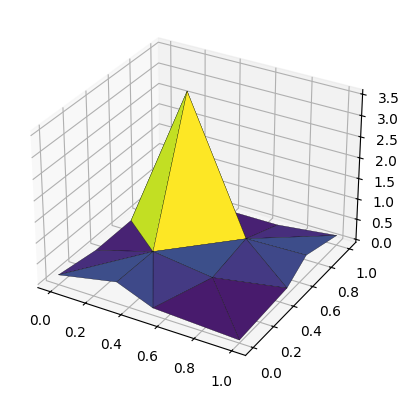

In [179]:
n = int(np.sqrt(len(ccs)))
n_points = n*n

# Calcul de b
b = np.zeros((n*n,1))
for e in e3:
    for s in range(3):
        index = e[s]
        b[index] += b_local(e,ccs)
for e in e4:
    for s in range(4):
        index = e[s]
        b[index] += b_local_q(e,ccs)

# Calcul de A
A = scps.csr_matrix((n_points, n_points), dtype=float)
for e in e3:
    A_loc = A_local_stiff(e,ccs)
    for i in range(3):
        for j in range(3):
            A[e[i],e[j]] += A_loc[i,j]
for e in e4:
    A_loc = A_local_stiff_q(e,ccs)
    for i in range(4):
        for j in range(4):
            A[e[i],e[j]] += A_loc[i,j]

# Conditions de Dirichlet
for s in dds:
    b[s] = u_d(ccs[s,0], ccs[s,1])
    A[s,:] = np.zeros((1,n_points))
    A[s,s] = 1

# Conditions de Neumann
for edge in nns:
    i, j = edge
    pi = ccs[i]
    pj = ccs[j]
    dist = np.linalg.norm(pj - pi)
    g_moy = 0.5 * (g(pi[0],pi[1]) + g(pj[0],pj[1]))
    contribution = g_moy * dist / 2
    b[i] += contribution
    b[j] += contribution

# Calcul de la solution
x = np.linalg.solve(A.toarray(),b)
show(ccs,x[:,0])

**Compléments  :  un nouveau terme dans l'EDP**

## Questions

Nous considérons le problème aux dérivées partielles suivant :

\begin{cases}
-\Delta u(x, y) + c_0 u(x, y) = f(x, y), & \text{dans } \Omega, \\
u(x, y) = 0, & \text{sur } \partial\Omega,
\end{cases}

où $ c_0 > 0 $ est une constante et $ f \in L^2(\Omega) $.

### 1. Formulation variationnelle

On multiplie l'équation par une fonction test $ w \in H_0^1(\Omega) $ et on intègre sur $ \Omega $ :

$$
\int_{\Omega} -\Delta u  w \, dx + c_0 \int_{\Omega}  u w \, dx = \int_{\Omega} f w \, dx
$$

De plus, par théorème de Green et puisque $u(x, y) = 0$ sur $\partial\Omega$, on a :

$$
\int_{\Omega} -\Delta u  w \, dx = \int_{\Omega} \nabla u \cdot \nabla w \, dx
$$

On obtient donc :

$$
\int_{\Omega} \nabla u \cdot \nabla w \, dx + c_0 \int_{\Omega} u w \, dx = \int_{\Omega} f w \, dx
$$

La formulation variationnelle de ce problème peut donc s'écrire : \
Trouver $ u \in H_0^1(\Omega) $ tel que :

$$
\forall w \in H_0^1(\Omega), \quad \int_{\Omega} \nabla u \cdot \nabla w \, dx + c_0 \int_{\Omega} u w \, dx = \int_{\Omega} f w \, dx
$$

#### Existence et unicité

On définit :

$$
a(u, w) = \int_{\Omega} \nabla u \cdot \nabla w \, dx + c_0 \int_{\Omega} u w \, dx \quad et \quad l(w) = \int_{\Omega} f w \, dx
$$

La forme $ a(\cdot, \cdot) $ est :

- Bilinéaire, par linéarité de l'intégrale et du gradient
- Continue sur $ H_0^1(\Omega) $ , par Cauchy-Schwarz
- Coercive, car pour tout $ w \in H_0^1(\Omega) $ :

$$
a(w, w) = \|\nabla w\|_{L^2}^2 + c_0 \|w\|_{L^2}^2 \geq \min(1, c_0) \|w\|_{H^1}^2
$$

La forme $ l(\cdot) $ est :

- Linéaire, par linéarité de l'intégrale
- Continue sur $ H_0^1(\Omega) $

Par théorème de Lax-Milgram, il existe une unique solution $ u \in H_0^1(\Omega) $ solution de ce problème.



### 2. Discrétisation par éléments finis

On approxime $ u $ par $ u_h \in V_h \subset H_0^1(\Omega) $, avec $V_h$ un espace vectoriel de dimension $ \dim V_h = n $, et de base $ \{\eta_k\}_{k=1}^n $.

On cherche $ u_h \in V_h $ tel que :

$$
\forall w_h \in V_h, \quad \int_{\Omega} \nabla u_h \cdot \nabla w_h \, dx + c_0 \int_{\Omega} u_h w_h \, dx = \int_{\Omega} f w_h \, dx
$$

En posant $ u_h = \sum_{j=1}^n x_j \eta_j $ et $ w_h = \eta_i $, on obtient :

$$
\sum_{j=1}^n x_j \left( \int_{\Omega} \nabla \eta_j \cdot \nabla \eta_i \, dx + c_0 \int_{\Omega} \eta_j \eta_i \, dx \right) = \int_{\Omega} f \eta_i \, dx
$$

Ce qui donne le système linéaire :

$$
A x = b,
$$
avec :

$$
A_{ij} = \int_{\Omega} \nabla \eta_i \cdot \nabla \eta_j \, dx + c_0 \int_{\Omega} \eta_i \eta_j \, dx, \quad
b_i = \int_{\Omega} f \eta_i \, dx
$$

#### Existence et unicité

La matrice $ A $ est symétrique définie positive. En effet, pour tout $ x \in \mathbb{R}^n \setminus \{0_{\mathbb{R}^n}\} $ :

$$
x^T A x = \int_{\Omega} \left| \sum x_i \nabla \eta_i \right|^2 dx + c_0 \int_{\Omega} \left( \sum x_i \eta_i \right)^2 dx > 0
$$

Le système linéaire admet donc une unique solution $ x $, d'où une unique solution discrète $ u_h \in V_h $.



In [180]:
def mass_matrix(c0, alpha):
#
# Construction de la matrice de masse relative à un élément triangle
##########################################################################
    M = np.array([[1/12, 1/24, 1/24],
                  [1/24, 1/12, 1/24],
                  [1/24, 1/24, 1/12]])
    return c0 * alpha * M

def mass_matrix_q(c0, alpha):
#
# Construction de la matrice de masse relative à un élément quadrangle
##########################################################################
    M = np.array([[1/9, 1/18, 1/36, 1/18],
                  [1/18, 1/9, 1/18, 1/36],
                  [1/36, 1/18, 1/9, 1/18],
                  [1/18, 1/36, 1/18, 1/9]])
    return c0 * alpha * M



In [181]:
def A_local(e,coordinates,c0):
#
# Construction de la matrice A relative à un élément triangle
##########################################################################
    p1 = e[0]
    p2 = e[1]
    p3 = e[2]

    x1 = coordinates[p1,0]
    y1 = coordinates[p1,1]
    x2 = coordinates[p2,0]
    y2 = coordinates[p2,1]
    x3 = coordinates[p3,0]
    y3 = coordinates[p3,1]

    # Calcul de alpha
    a = np.array([[x2 - x1,x3 - x1],[y2 - y1,y3 - y1]])
    alpha = np.linalg.det(a)

    # Calcul de la matrice de masse
    A_local_mass = mass_matrix(c0, alpha)

    return A_local_stiff(e,coordinates) + A_local_mass


In [182]:
def A_local_q(e,coordinates,c0):
#
# Construction de la matrice A relative à un élément quadrangle
##########################################################################
    p1 = e[0]
    p2 = e[1]
    p3 = e[2]
    p4 = e[3]

    x1 = coordinates[p1,0]
    y1 = coordinates[p1,1]
    x2 = coordinates[p2,0]
    y2 = coordinates[p2,1]
    x3 = coordinates[p3,0]
    y3 = coordinates[p3,1]
    x4 = coordinates[p4,0]
    y4 = coordinates[p4,1]

    # Calcul de alpha
    a = np.array([[x2 - x1,x4 - x1],[y2 - y1,y4 - y1]])
    alpha = np.linalg.det(a)

    # Calcul de la matrice de masse
    A_local_mass = mass_matrix_q(c0, alpha)

    return A_local_stiff_q(e,coordinates) + A_local_mass


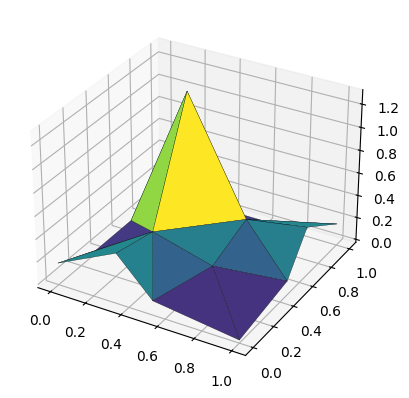

In [183]:
n = int(np.sqrt(len(ccs)))
c0 = 1
n_points = n*n

# Construction de b
b = np.zeros((n*n,1))
for e in e3:
    for s in range(3):
        index = e[s]
        b[index] += b_local(e,ccs)
for e in e4:
    for s in range(4):
        index = e[s]
        b[index] += b_local_q(e,ccs)

# Construction de A
A = scps.csr_matrix((n_points, n_points), dtype=float)
for e in e3:
    A_loc = A_local(e,ccs,c0)
    for i in range(3):
        for j in range(3):
            A[e[i],e[j]] += A_loc[i,j]
for e in e4:
    A_loc = A_local_q(e,ccs,c0)
    for i in range(4):
        for j in range(4):
            A[e[i],e[j]] += A_loc[i,j]

# Conditions de Dirichlet
for s in dds:
    b[s] = u_d(ccs[s,0], ccs[s,1])
    A[s,:] = np.zeros((1,n_points))
    A[s,s] = 1

# Conditions de Neumann
for edge in nns:
    i, j = edge
    pi = ccs[i]
    pj = ccs[j]
    dist = np.linalg.norm(pj - pi)
    g_moy = 0.5 * (g(pi[0],pi[1]) + g(pj[0],pj[1]))
    contribution = g_moy * dist / 2
    b[i] += contribution
    b[j] += contribution

# Calcul de la solution
x = np.linalg.solve(A.toarray(),b)
show(ccs,x[:,0])